# An End-to-End Classification Test
As the last step, you are given a dataset called `data/ccdefault.csv`. The dataset represents default of credit card clients. It has 30,000 cases and 24 different attributes. More details about the dataset is available at `data/ccdefault.txt`. In this task you should make three models, compare their results and conclude the ideal solution. Here are the suggested steps:
1. Load the data.
2. Carry out some exploratory analyses (e.g., how various features and the target variable are distributed).
3. Train a model to predict the target variable (risk of `default`).
  - Employ three different models (logistic regression, decision tree, and random forest).
  - Compare the models' performances (e.g., AUC).
  - Defend your choice of best model (e.g., what are the strength and weaknesses of each of these models?).
4. What more would you do with this data? Anything to help you devise a better solution?

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('lab2').getOrCreate()

## Explore data

In [2]:
df = spark.read.csv('data/ccdefault.csv', header=True, inferSchema=True)

### Schema

In [3]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- DEFAULT: integer (nullable = tru

### Size

In [4]:
df.count()

30000

### Look at data

In [5]:
df.limit(5).toPandas()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Import and configure dependencies for aggregating and visualizing

### Visualize distributions of some variables

In [6]:
from pyspark.sql.functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("fivethirtyeight")

#### Distribution of sex

In [7]:
df_sex = df.groupBy("SEX").count().sort(asc("SEX")).toPandas()
df_sex

,SEX,count
0,1,11888
1,2,18112


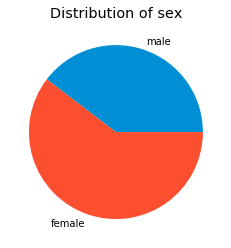

In [8]:
labels = ["male", "female"]
plt.pie(df_sex['count'], labels=labels);
plt.title('Distribution of sex');

#### Distribution of education

In [9]:
df_education = df.groupBy("EDUCATION").count().sort(asc("EDUCATION")).toPandas()
df_education

,EDUCATION,count
0,0,14
1,1,10585
2,2,14030
3,3,4917
4,4,123
5,5,280
6,6,51


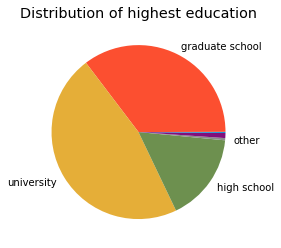

In [10]:
labels = ["", "graduate school", "university", "high school", "other", "", ""]
plt.pie(df_education['count'], labels=labels);
plt.title('Distribution of highest education');

#### Distribution of relationship status

In [11]:
df_marriage = df.groupBy("MARRIAGE").count().sort(asc("MARRIAGE")).toPandas()
df_marriage

,MARRIAGE,count
0,0,54
1,1,13659
2,2,15964
3,3,323


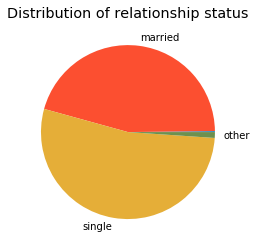

In [12]:
labels = ["", "married", "single", "other"]
plt.pie(df_marriage['count'], labels=labels);
plt.title('Distribution of relationship status');

#### Distribution of ages

In [13]:
df_age = df.groupBy("AGE").count().sort(asc("AGE")).toPandas()

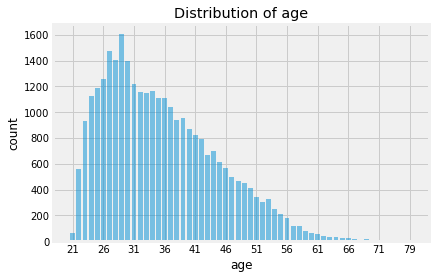

In [14]:
import numpy as np
x_pos = np.arange(df_age["AGE"].size)
x_tick_pos = x_pos[0::5]
x_tick_labels = df_age["AGE"][0::5]
plt.bar(x_pos, df_age["count"], align='center', alpha=0.5);
plt.xticks(x_tick_pos, x_tick_labels);
plt.xlabel('age');
plt.ylabel('count');
plt.title('Distribution of age');

#### Distribution of given credit

In [15]:
df_credit = df.select("LIMIT_BAL").toPandas()

In [16]:
df_credit

,LIMIT_BAL
0,20000
1,120000
2,90000
3,50000
4,50000
...,...
29995,220000
29996,150000
29997,30000
29998,80000


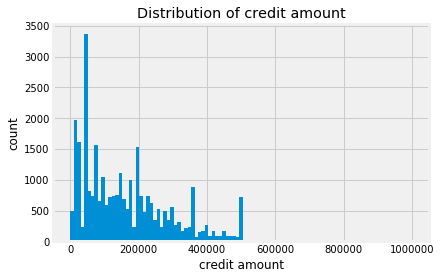

In [17]:
bins = np.linspace(0, 1000000, 100)
plt.hist(df_credit["LIMIT_BAL"], bins=bins)
plt.xlabel('credit amount');
plt.ylabel('count');
plt.title('Distribution of credit amount');

#### Distribution of defaults

In [18]:
df_defaults = df.groupBy("DEFAULT").count().sort(asc("DEFAULT")).toPandas()
df_defaults

,DEFAULT,count
0,0,23364
1,1,6636


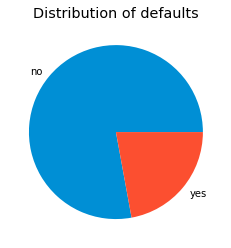

In [19]:
labels = ["no", "yes"]
plt.pie(df_defaults['count'], labels=labels);
plt.title('Distribution of defaults');

### Statistical summary of some variables

In [20]:
# TODO

## Prepare data

In [21]:
df = df.withColumnRenamed("DEFAULT", "label").drop("ID")
df.printSchema()

root
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- label: integer (nullable = true)



Divide columns into label, numerical and categorical columns

In [22]:
# label columns
col_label = ["label"]

# categorical columns
col_cat = ["SEX", "EDUCATION", "MARRIAGE"]

# numerical columns
col_cont = [col for col in df.columns if col not in col_label and col not in col_cat]

Check for null values

In [23]:
for c in col_cont:
    print(c, df.where(col(c).isNull()).count())

LIMIT_BAL 0
AGE 0
PAY_0 0
PAY_2 0
PAY_3 0
PAY_4 0
PAY_5 0
PAY_6 0
BILL_AMT1 0
BILL_AMT2 0
BILL_AMT3 0
BILL_AMT4 0
BILL_AMT5 0
BILL_AMT6 0
PAY_AMT1 0
PAY_AMT2 0
PAY_AMT3 0
PAY_AMT4 0
PAY_AMT5 0
PAY_AMT6 0


In [24]:
for c in col_cat:
    print(c, df.where(col(c).isNull()).count())

SEX 0
EDUCATION 0
MARRIAGE 0


In [25]:
print("label", df.where(col("label").isNull()).count())

label 0


### Scaler for continuous features

In [26]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, VectorAssembler

assembler_cont = VectorAssembler(
    inputCols=col_cont,
    outputCol="features_continuous")

scaler_cont = StandardScaler(inputCol="features_continuous", outputCol="features_continuous_scaled")

### One-hot encoder for categorical features

One-hot encoder for sex

In [27]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
indexer_sex = StringIndexer(inputCol="SEX", outputCol="sex_index")
encoder_sex = OneHotEncoder(inputCol="sex_index", outputCol="sex_vec")

One-hot encoder for education

In [28]:
indexer_education = StringIndexer(inputCol="EDUCATION", outputCol="education_index")
encoder_education = OneHotEncoder(inputCol="education_index", outputCol="education_vec")

One-hot encoder for marriage

In [29]:
indexer_marriage = StringIndexer(inputCol="MARRIAGE", outputCol="marriage_index")
encoder_marriage = OneHotEncoder(inputCol="marriage_index", outputCol="marriage_vec")

Assembler to combine all encoded and scaled features

In [30]:
columns = ['features_continuous_scaled', 'sex_vec', 'education_vec', 'marriage_vec']
assembler_all = VectorAssembler(
    inputCols=columns,
    outputCol="features")


### Create pipeline

In [31]:
from pyspark.ml import Pipeline

pipeline_cont = Pipeline(stages=[assembler_cont, scaler_cont])
pipeline_cat = Pipeline(stages=[indexer_sex, encoder_sex, indexer_education, encoder_education, indexer_marriage, encoder_marriage])
pipeline = Pipeline(stages=[pipeline_cont, pipeline_cat, assembler_all])

### Scale and encode features

In [32]:
df_prepared = pipeline.fit(df).transform(df)
dataset = df_prepared.select("features", "label")

In [33]:
dataset.select("features").head()

Row(features=SparseVector(30, {0: 0.1541, 1: 2.6036, 2: 1.7797, 3: 1.6706, 4: -0.8355, 5: -0.8553, 6: -1.7649, 7: -1.7391, 8: 0.0531, 9: 0.0436, 10: 0.0099, 15: 0.0299, 20: 1.0, 21: 1.0, 28: 1.0}))

### Split into training and test data

In [69]:
(train_set, test_set) = dataset.randomSplit([0.7, 0.3])

In [70]:
train_set.limit(10).toPandas()

,features,label
0,"(0.15414535998894324, 2.7121132760041533, 0.88...",0
1,"(3.4682705997512233, 3.471504993285316, -1.779...",0
2,"(2.2351077198396774, 4.230896710566479, 0.8898...",1
3,"(2.3121803998341486, 4.230896710566479, -0.889...",0
4,"(2.7746164798009785, 3.5799895243254825, 0.889...",0
5,"(1.1560901999170743, 2.7121132760041533, -0.88...",0
6,"(1.7726716398728475, 3.471504993285316, -1.779...",0
7,"(1.7726716398728475, 4.339381241606645, -1.779...",1
8,"(0.5395087599613014, 7.26846357969113, 0.88983...",0
9,"(2.3892530798286202, 4.881803896807476, -1.779...",0


## Models

### Logistic regression

In [35]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10)
lr_model = lr.fit(train_set)

trainingSummary = lr_model.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

objectiveHistory:
0.5284625520293043
0.48488995111893807
0.4813827912573713
0.4799316526873965
0.47372888798981627
0.4707806398895549
0.4688469747476681
0.46848671547249643
0.46832606466154036
0.4681967633816858
0.4681033822686606


ROC table with FPR and TPR for different thresholds

In [36]:
trainingSummary.roc.toPandas()

,FPR,TPR
0,0.000000,0.000000
1,0.003428,0.032967
2,0.007284,0.064857
3,0.010773,0.097608
4,0.014201,0.130575
...,...,...
98,0.972578,0.995044
99,0.984881,0.996768
100,0.996817,0.999785
101,1.000000,1.000000


AUC

In [37]:
trainingSummary.areaUnderROC

0.7185923540481399

Set model threshold to maximize F-measure

In [38]:
fmeasure = trainingSummary.fMeasureByThreshold
fmeasure.toPandas()

,threshold,F-Measure
0,7.175806e-01,0.063093
1,6.300205e-01,0.118949
2,5.927254e-01,0.171917
3,5.649074e-01,0.221208
4,5.391322e-01,0.264768
...,...,...
96,4.189146e-02,0.368900
97,3.488426e-02,0.367266
98,2.591935e-02,0.364870
99,8.610827e-03,0.362982


In [39]:
max_fmeasure = fmeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()['max(F-Measure)']
max_fmeasure

0.5064581917063222

In [41]:
best_threshold = fmeasure.where(fmeasure['F-Measure'] == max_fmeasure) \
    .select('threshold').head()['threshold']
best_threshold

0.2837530540655644

In [42]:
lr.setThreshold(best_threshold)

LogisticRegression_c37a83bbaa48

### Decision tree classification

In [68]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt_model = dt.fit(train_set)


AttributeError: 'DecisionTreeClassificationModel' object has no attribute 'summary'